In [1]:
version = "REPLACE_PACKAGE_VERSION"

---
# Assignment 4 Part 1: Sampling a Data Stream (50 pts)

In this assignment, we're going to implement two algorithms for sampling a data stream. 

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

We are interested in understanding the distribution (counts) of emojis in a (potentially unlimited) stream of tweets. However, remember that one of the biggest challenges in mining data streams is that **we have limited storage capacity for the very high volume of incoming data, which may arrive at a very high velocity as well**. So in this week's assignments, **we cannot store or process all tweets at once, but are constrained to deal with only one or a few tweets at a time**. Sampling allows us to maintain a compact representation of the entire data stream and we hope that the distribution of emojis in the sample we collect sheds light on the overall distribution of emojis in the data stream. 

The `TwitterStream` class defined below is used to simulate a Twitter stream. It works the same way as a `list`, `tuple` or any other `iterable`s that you may have worked with before --- you can loop over it to receive **one tweet at a time**. Each tweet may or may not contain emojis. There's also a helper function `extract_emojis` that helps you extract all emojis from a piece of text. It may be also useful to know that the variable `UNICODE_EMOJI` is a collection of all emojis that are circulating around the world. 

In [3]:
import json
from emoji import UNICODE_EMOJI

def extract_emojis(text):
    """
    Extract all emojis from a str
    """
    return [ch for ch in text if ch in UNICODE_EMOJI]

class TwitterStream:
    """
    Used to simulate a Twitter stream. 
    """
    
    def __init__(self, data_file):
        self.data_file = data_file
        self.data = open(self.data_file, "r")
    
    def __iter__(self):
        return self.reset()
    
    def __next__(self):
        next_line = self.data.readline()
        if next_line:
            return json.loads(next_line)["text"]
        else:
            raise StopIteration
    
    def __del__(self):
        if not self.data.closed:
            self.data.close()
    
    def reset(self):
        if not self.data.closed:
            self.data.close()
        self.data = open(self.data_file, "r")
        return self

In [4]:
tw = ['Lmaoooooo love you allll', 
'RT @kaseykreated: BEST CITY IN MISSOURI! Let’s argue 😂😂 https://t.co/p7DWK5OAd5', 
'Hubble Hooks a One-Arm Galaxy via NASA https://t.co/csOJhfJMpj https://t.co/Aer6ILkskg', 
'RT @makio_elecom: 先日はアンジュさんをネタにしてしまい、大変申し訳ございませんでした。 https://t.co/9cO6IPV3hB', 
'#tell حبيبتي شكراًًً💘💘💘']
test = []
for i in tw:
    test.append(extract_emojis(i))
    
test
    


[[], ['😂', '😂'], [], [], ['💘', '💘', '💘']]

In [5]:
import collections

flat_test = [item for sublist in test for item in sublist]

counter = collections.Counter(flat_test)
counter

Counter({'😂': 2, '💘': 3})

Understanding how the `TwitterStream` class works is not essential to completing this assignment. You may interact with an instance of the `TwitterStream` class in one of the following two ways. 

In [6]:
twitter_stream = TwitterStream("assets/tweets")  # instantiate a Twitter stream from a data file

# use a for-loop to iterate through the stream, just like iterating over a list
for index, tweet in enumerate(twitter_stream):
    print(tweet)
    if index >= 3:  # only prints the first 4 tweets
        break

twitter_stream.reset() # reset the stream so that it begins with the first tweet
print()

# OR
# use a while-loop together with the "next" function to retrieve one tweet from the stream at a time
index = 0
while index < 4: 
    print(index, next(twitter_stream)) # the built-in "next" function retrieves the next item in an iterator
    index += 1

del twitter_stream, index

Recently arrived in Australia - just been out on my evening dog walk and decided to give @petercrouch podcast a listen - wow...what have I been missing - absolutely hilarious! #thatpetercrouchpodcast
Lmaoooooo love you allll
Good morning! kita mo nga naman isang panibagong araw para maging malungkot ulit🤧
Here we go ⚓️

0 Recently arrived in Australia - just been out on my evening dog walk and decided to give @petercrouch podcast a listen - wow...what have I been missing - absolutely hilarious! #thatpetercrouchpodcast
1 Lmaoooooo love you allll
2 Good morning! kita mo nga naman isang panibagong araw para maging malungkot ulit🤧
3 Here we go ⚓️


Many sampling algorithms require "tossing a coin", that is, a psudo-random generator (PRG). To make sure the autograder can grade your work correctly, we need a special "history-preserving" PRG that's defined below. You don't have to worry about its definition but just be aware that it works exactly the same way as the `random` library. An example usage is also provided below. 

In [7]:
from random import Random
from collections import defaultdict

class HistPresvRandom:
    """
    History-preserving Random Number Generator
    """
    
    def __init__(self, seed=None):
        self.prg = Random(seed)
        self.hist = defaultdict(list)
    
    def random(self): # works exactly like random.random()
        num = self.prg.random()
        self.hist["random"].append(num)
        return num
    
    def sample(self, population): # works exactly like random.sample(population, 1)[0]
        num = self.prg.sample(population, 1)[0]
        self.hist["sample"].append(num)
        return num

hist_presv_random = HistPresvRandom(0)
print(f'"random" method: {hist_presv_random.random()}')
print(f'"sample" method: {hist_presv_random.sample(range(10))}')

del hist_presv_random

"random" method: 0.8444218515250481
"sample" method: 6


In [8]:
hist_presv_random = HistPresvRandom(42)
hist_presv_random.random()



0.6394267984578837

## Question 1: Random Sampling (20 pts)

As a warm-up, let's implement the Random Sampling algorithm referred to as "First Attempt" in the lecture slides. 

A partially completed `RandomSampler` class is given to you below. Your job is to complete the following two functions:

* `_process_new_item`: it receives a single item and decides whether the item should be added to `self.sample`. It also ensures `self.counts` always has the most updated counts of emojis that are extracted from the tweets in `self.sample`. 


* `do_sampling`: it receives a stream object and iterates over the stream. During each iteration, it processes a new item as specified by the Random Sampling algorithm. Finally it returns a copy of `self.sample` and `self.counts` for grading at every iteration, which you don't need to worry about. **However, please do make sure you don't inadvertently change the indentation of the `yield` statement.**

At the end of every iteration, the autograder checks the content of your `self.sample` and `self.counts`. Below is an example content of both. 

```
self.sample:
['Lmaoooooo love you allll', 
'RT @kaseykreated: BEST CITY IN MISSOURI! Let’s argue 😂😂 https://t.co/p7DWK5OAd5', 
'Hubble Hooks a One-Arm Galaxy via NASA https://t.co/csOJhfJMpj https://t.co/Aer6ILkskg', 
'RT @makio_elecom: 先日はアンジュさんをネタにしてしまい、大変申し訳ございませんでした。 https://t.co/9cO6IPV3hB', 
'#tell حبيبتي شكراًًً💘💘💘']

self.counts:
defaultdict(<class 'int'>, {'😂': 2, '💘': 3})
```

In [9]:
from collections import defaultdict

class RandomSampler:
    
    def __init__(self, in_sample_prob, seed=None):
        
        self.in_sample_prob = in_sample_prob
        self.random = HistPresvRandom(seed) # used whenever randomness is needed in your solution
        self.sample, self.counts = list(), defaultdict(int) # recommended to use defaultdict, but an ordinary dict works fine too
    
    def _process_new_item(self, item):
        """
        Applies random sampling to a newly arrived item
        """
#         hist_presv_random = HistPresvRandom(seed)
        
#         coin_toss = hist_presv_random.random()
        
        import random
        coin_toss = self.random.random()
        
#         hist_presv_random = HistPresvRandom()
        
        
#         coin_toss = hist_presv_random.random()
        
#         coin_toss = hist_presv_random.random()
        
        if coin_toss < self.in_sample_prob:
            self.sample.append(item)
            
            import collections

            emojis = []
            emojis.append(extract_emojis(item))

            flat_samp = [item for sublist in emojis for item in sublist]

            for e in flat_samp:
                self.counts[e] +=1



#         counter = collections.Counter(flat_samp)
#         self.counts = counter
            
#             return self.sample, self.counts
            
        # YOUR CODE HERE
        #raise NotImplementedError()
    
    def do_sampling(self, stream):
        """
        Iterates over a stream and performs random sampling
        """
        
        self.sample.clear() # clear the existing sample
        self.counts.clear() # clear the existing counts
        
        x = 0
        for item in stream: # iterate over the stream
            
            self._process_new_item(item)
            
            # YOUR CODE HERE
            #raise NotImplementedError()
            
            # returns a copy of sample and counts at the end of every iteration for grading - code given
            yield self.sample.copy(), self.counts.copy()
#             print('after index'+str(x)+':', self.sample)

In [10]:
twitter_stream = TwitterStream("assets/tweets")

# Sanity checks for a trivial case - always includes a new tweet in the sample
in_sample_prob, seed = .10, 42
stu_ans = RandomSampler(in_sample_prob, seed)

# Collect all emojis that appeared
emojis_appeared = set()
for tweet in twitter_stream:
    emojis_appeared = emojis_appeared.union(extract_emojis(tweet))

# Do sampling. Don't have to collect the results. Just exhaust the stream
stream_size = 0
for _ in stu_ans.do_sampling(twitter_stream):
    stream_size += 1
    
stu_ans.sample

['Lmaoooooo love you allll',
 'RT @kaseykreated: BEST CITY IN MISSOURI! Let’s argue 😂😂 https://t.co/p7DWK5OAd5',
 'Hubble Hooks a One-Arm Galaxy via NASA https://t.co/csOJhfJMpj https://t.co/Aer6ILkskg',
 'RT @makio_elecom: 先日はアンジュさんをネタにしてしまい、大変申し訳ございませんでした。 https://t.co/9cO6IPV3hB',
 '#tell حبيبتي شكراًًً💘💘💘',
 '敵艦は逃がしてもぉ～・・・司令官は逃がさないぴょ～ん！',
 'Z moich ub ufam tylko nayeon.',
 "@bsdhanoa Seems morphed..the gravel isn't moving at all",
 '@skts_babyc 顔を隠してても滲み出る可愛いオーラですよ...すき😘',
 '@i0i73 툥 안무평가 어쩌구했는데 영ㅇ상 길어서 띄엄띄엄 보는데 그닥 그럼',
 'RT @ipatchyz: อยากกินไอติมใส่ข้าวเหนียว 🥺',
 '@bunnyderx @chwten 😔😔',
 'RT @inkokfc: ふくちゃん💕ぷくぷく🥰 https://t.co/GIm5E4wbMW',
 'コロナの外出自粛とか禁止のせいでネットが重い\u3000俺たち引きこもりの帯域と娯楽を奪うな',
 '@t_Ace_ZERO はっ😍😍😍😍😍\nじゃ、じゃあ。私もLive行ったら全部受け止めてね😙😙😙\nそれまで生き延びてみせる🔥',
 'RT @ShibuyaNailEN: ❣️モデルさん募集❣️\n❣️急募❣️\n\n明日3/29(日)\n12:00,13:30,16:00,17:30〜\n🌟オフ込み2000円🌟\n\n亀裂のない方、長さ出しのない方お願い致します🙏🏻\n\nご興味がある方は注意事項をお読み頂きDMにて連絡くだ…',
 '今日は職場が殺伐としてる\n\nまぁ昨日色々あったからしょうがないんだけど、そのギスギス感をみてて腹抱えて笑ってる',
 '@occoll

In [11]:
twitter_stream = TwitterStream("assets/tweets")

in_sample_prob, seed = 0.1, 42
stu_ans = RandomSampler(in_sample_prob, seed)
stu_res = stu_ans.do_sampling(twitter_stream)
stu_res

<generator object RandomSampler.do_sampling at 0x7f00f5759b50>

In [12]:
# Autograder tests

twitter_stream = TwitterStream("assets/tweets")

# Sanity checks for a trivial case - always includes a new tweet in the sample
in_sample_prob, seed = 1.0, 42
stu_ans = RandomSampler(in_sample_prob, seed)

# Collect all emojis that appeared
emojis_appeared = set()
for tweet in twitter_stream:
    emojis_appeared = emojis_appeared.union(extract_emojis(tweet))

# Do sampling. Don't have to collect the results. Just exhaust the stream
stream_size = 0
for _ in stu_ans.do_sampling(twitter_stream):
    stream_size += 1


assert isinstance(stu_ans.sample, list), "Q1: Your sample should be of type list. "

assert isinstance(stu_ans.counts, dict), "Q1: Your emoji counts should be of type dict. "

assert len(stu_ans.sample) == stream_size, f"Q1: When in_sample_prob == {in_sample_prob}, your sample should contain all tweets. "

assert len(stu_ans.counts) == len(emojis_appeared), f"Q1: The length of your emoji counts ({len(stu_ans.counts)}) differs from the correct answer ({len(emojis_appeared)}). "

assert not (emojis_appeared - set(stu_ans.counts.keys())), f"Q1: Your emoji counts don't include {emojis_appeared - set(stu_ans.counts.keys())}. "

assert not (set(stu_ans.counts.keys()) - emojis_appeared), f"Q1: Your emoji counts contain extra emojis: {set(stu_ans.counts.keys()) - emojis_appeared}. "


# Re-define variables for the hidden tests
in_sample_prob, seed = 0.1, 42
stu_ans = RandomSampler(in_sample_prob, seed)
stu_res = stu_ans.do_sampling(twitter_stream)

# Some hidden tests


del in_sample_prob, seed, twitter_stream, stu_ans, stu_res, emojis_appeared, stream_size

Let's see what the emoji distribution is after all tweets are processed.

In [13]:
in_sample_prob, seed = 0.1, 42
stu_ans = RandomSampler(in_sample_prob, seed)

# Do sampling. Don't have to collect the results. Just exhaust the stream
for _ in stu_ans.do_sampling(TwitterStream("assets/tweets")):
    pass

sorted_counts = {emoji: stu_ans.counts[emoji] for emoji in sorted(stu_ans.counts.keys(), key=stu_ans.counts.get, reverse=True)}
print(sorted_counts)

{'😂': 194, '😭': 69, '❤': 57, '🤣': 51, '✨': 50, '🏻': 40, '🔥': 37, '🥺': 35, '🙏': 32, '👏': 32, '😍': 30, '👍': 29, '♥': 23, '💕': 21, '🇸': 20, '♀': 20, '😅': 20, '☺': 18, '🥰': 17, '🇦': 16, '😎': 16, '🏽': 16, '💜': 16, '💚': 15, '🏾': 15, '😊': 14, '😆': 14, '😢': 14, '🍍': 14, '💪': 13, '😳': 13, '😩': 12, '‼': 12, '♂': 12, '🤭': 12, '💙': 11, '👇': 11, '💖': 10, '😱': 10, '💛': 10, '😹': 10, '🤔': 9, '🖤': 9, '🎉': 9, '🚨': 9, '🙄': 9, '♻': 9, '🙌': 8, '💦': 8, '❗': 8, '😷': 8, '🤷': 8, '😈': 8, '💀': 8, '⚡': 8, '😔': 7, '🥵': 7, '😁': 7, '⭕': 7, '🏅': 7, '💗': 7, '🌹': 7, '✌': 7, '⚠': 7, '😘': 6, '🌟': 6, '😌': 6, '🌸': 6, '🗣': 6, '🤪': 6, '😤': 6, '🤦': 6, '❣': 5, '🍑': 5, '💔': 5, '✊': 5, '🤤': 5, '💓': 5, '🦋': 5, '😇': 5, '💎': 5, '🇬': 5, '🇨': 5, '😥': 5, '⚰': 5, '🙂': 5, '👋': 5, '↙': 5, '👉': 5, '🐰': 5, '🐨': 5, '💣': 5, '🥳': 5, '✅': 5, '🐬': 5, '💘': 4, '😉': 4, '😐': 4, '🌺': 4, '💝': 4, '🇪': 4, '▶': 4, '🇧': 4, '👩': 4, '🙃': 4, '😄': 4, '😚': 4, '🤩': 4, '☀': 4, '🏃': 4, '⭐': 4, '▫': 4, '🇳': 4, '🔴': 4, '😙': 3, '🐶': 3, '☝': 3, '🇷': 3, '🥴': 3, '😡': 

Visualised in a bar graph, the emoji distribution seems to resemble a [Power Law](https://en.wikipedia.org/wiki/Power_law) distribution. A few emojis are used a lot while the majority of the emojis are rarely used. 

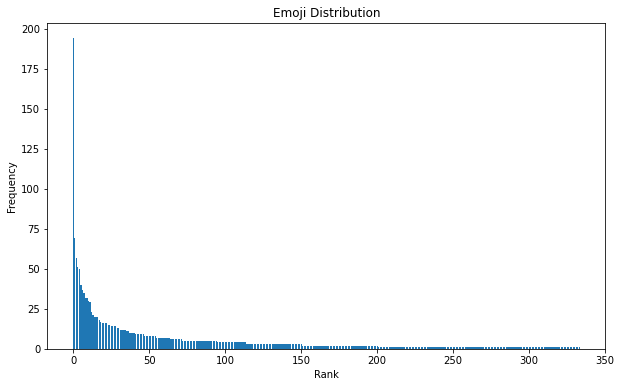

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_counts)), sorted_counts.values())
ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")
ax.set_title("Emoji Distribution")

del fig, ax

## Question 2: Reservoir Sampling (30 pts)

With reference to the lecture slides, let's now implement the Reservoir Sampling algorithm. 

A partially completed `ReservoirSampler` class similar in structure to `RandomSampler` is given to you below. Your job is to complete the same two functions:

* `_process_new_item`: it receives a single item as well as the index of the item in the stream, and decides whether the item should be added to `self.sample`. **Please always *append* the new item to the end of your `self.sample` instead of replacing an old item with it.** This function also ensures `self.counts` always has the most updated counts of emojis that are extracted from the tweets *currently* in `self.sample`, which means that **the counts of emojis must be adjusted in the event of adding or removing an emoji to/from the sample**. Moreover, an emoji with a count of zero must be completely dropped from `self.counts`. 


* `do_sampling`: it receives a stream object and iterates over the stream. During each iteration, it processes a new item as specified by the Reservoir Sampling algorithm. Finally it returns a copy of `self.sample` and `self.counts` for grading at every iteration, which you don't need to worry about. **However, please do make sure you don't inadvertently change the indentation of the `yield` statement.**

At the end of every iteration, the autograder checks the content of your `self.sample` and `self.counts`. Below is an example content of both. 

```
self.sample:
['Recently arrived in Australia - just been out on my evening dog walk and decided to give @petercrouch podcast a listen - wow...what have I been missing - absolutely hilarious! #thatpetercrouchpodcast', 
'Lmaoooooo love you allll', 
'Good morning! kita mo nga naman isang panibagong araw para maging malungkot ulit🤧', 
'Here we go ⚓️']

self.counts:
defaultdict(<class 'int'>, {'🤧': 1, '⚓': 1})
```

In [23]:
from collections import defaultdict

class ReservoirSampler:
    
    def __init__(self, sample_size, seed=None):
        
        self.sample_size = sample_size
        self.random = HistPresvRandom(seed) # used whenever randomness is needed in your solution
        self.sample, self.counts = list(), defaultdict(int)
    
    def _process_new_item(self, item, index):
        """
        Decides whether a new item should be added to the sample and adjusts the counts accordingly
        """
        if (index) < self.sample_size:
            self.sample.append(item)
            
            import collections

            emojis = []
            emojis.append(extract_emojis(item))
            
            flat_samp = []
            flat_samp = [item for sublist in emojis for item in sublist]

            for e in flat_samp:
                self.counts[e] +=1
        else:
            if self.random.random() < (self.sample_size / (index)):
                self.sample.append(item)
                                       
                item_to_remove = self.random.sample(range(self.sample_size))
#                 emojis = []
#                 emojis.append(extract_emojis(self.sample[item_to_remove]))
                
#                 flat_samp = []
#                 flat_samp = [item for sublist in emojis for item in sublist] 
                
#                 for e in flat_samp:
#                     self.counts[e] -=1
                
#                     self.counts = {x:y for x,y in self.counts.items() if y!=0}
                
                self.sample.pop(item_to_remove)
                                       
#                 for i in self.sample[:-1]:
#                     pop_toss = self.random.sample(range(self.sample_size))
#                     self.sample.remove(i)
                        
                import collections
                
                self.counts = defaultdict(int)
                emojis = []

                for x in self.sample:
                    emojis.append(extract_emojis(x))

                flat_samp = [item for sublist in emojis for item in sublist]

                for e in flat_samp:
                    self.counts[e] +=1


                # YOUR CODE HERE
                #raise NotImplementedError()
    
    def do_sampling(self, stream):
        
        """
        Iterates over a stream and performs reservoir sampling
        """
        
        self.sample.clear() # clear the existing sample
        self.counts.clear() # clear the existing counts
        
        for index, item in enumerate(stream): # iterate over the stream
            self._process_new_item(item,index)
            
            
            # YOUR CODE HERE
            #raise NotImplementedError()
            
            # returns a copy of sample and counts at the end of every iteration for grading - code given
            yield self.sample.copy(), self.counts.copy()

In [22]:
HistPresvRandom(seed).sample(range(100))

81

In [24]:
# Autograder tests

twitter_stream = TwitterStream("assets/tweets")

# Sanity checks for a trivial case - use a large sample size to include all tweets
sample_size, seed = 100000, 0
stu_ans = ReservoirSampler(sample_size, seed)

# Collect all emojis that appeared
emojis_appeared = set()
for tweet in twitter_stream:
    emojis_appeared = emojis_appeared.union(extract_emojis(tweet))

# Do sampling. Don't have to collect the results. Just exhaust the stream
stream_size = 0
for _ in stu_ans.do_sampling(twitter_stream):
    stream_size += 1


assert isinstance(stu_ans.sample, list), "Q2: Your sample should be of type list. "

assert isinstance(stu_ans.counts, dict), "Q2: Your emoji counts should be of type dict. "

for emoji in stu_ans.counts:
    assert stu_ans.counts[emoji] > 0, f"Q2: {emoji} in your emoji counts has a zero count. "
    
assert len(stu_ans.sample) == stream_size, f"Q2: When sample_size is very large, your sample should contain all tweets. "

assert len(stu_ans.counts) == len(emojis_appeared), f"Q2: The length of your emoji counts ({len(stu_ans.counts)}) differs from the correct answer ({len(emojis_appeared)}). "

assert not (emojis_appeared - set(stu_ans.counts.keys())), f"Q2: Your emoji counts don't include {emojis_appeared - set(stu_ans.counts.keys())}. "

assert not (set(stu_ans.counts.keys()) - emojis_appeared), f"Q2: Your emoji counts contain extra emojis: {set(stu_ans.counts.keys()) - emojis_appeared}. "


# Re-define variables for the hidden tests
sample_size, seed = 100, 0
stu_ans = ReservoirSampler(sample_size, seed)
stu_res = stu_ans.do_sampling(twitter_stream)

# Some hidden tests


del sample_size, seed, twitter_stream, stu_ans, stu_res, emojis_appeared, stream_size

Let's see what the emoji distribution is after all tweets are processed.

In [25]:
sample_size, seed = 100, 0
stu_ans = ReservoirSampler(sample_size, seed)

# Do sampling. Don't have to collect the results. Just exhaust the stream
for _ in stu_ans.do_sampling(TwitterStream("assets/tweets")):
    pass

sorted_counts = {emoji: stu_ans.counts[emoji] for emoji in sorted(stu_ans.counts.keys(), key=stu_ans.counts.get, reverse=True)}
print(sorted_counts)

{'😭': 24, '🥰': 18, '❤': 11, '😂': 8, '💙': 8, '🥺': 7, '😍': 7, '🇸': 6, '🇺': 5, '✨': 4, '‼': 4, '♂': 3, '🏆': 3, '😘': 2, '👍': 2, '☺': 2, '❗': 2, '👩': 2, '🙃': 2, '😋': 2, '🔥': 2, '👑': 2, '💕': 2, '♥': 2, '😩': 2, '😏': 1, '🎶': 1, '☀': 1, '🎵': 1, '🐟': 1, '🐰': 1, '👫': 1, '💋': 1, '😈': 1, '💚': 1, '🏀': 1, '🏈': 1, '🎤': 1, '😠': 1, '🌈': 1, '⚽': 1, '✌': 1, '🏼': 1, '😷': 1, '🤦': 1, '🏻': 1, '🤓': 1, '🇦': 1, '🤷': 1, '🏿': 1, '🐳': 1, '💰': 1, '✅': 1, '🥇': 1, '👏': 1, '👉': 1, '\U0001f9be': 1, '😞': 1, '📸': 1, '🤑': 1, '🙏': 1, '🏾': 1, '🙆': 1, '🏽': 1, '🍪': 1, '😇': 1, '😉': 1, '🥴': 1, '🏯': 1, '🦅': 1, '😱': 1, '😓': 1, '👇': 1, '🤗': 1, '💓': 1, '😤': 1, '🐱': 1, '🐥': 1, '🍼': 1, '😪': 1}


Visualised in a bar graph, the emoji distribution seems to somewhat resemble a [Power Law](https://en.wikipedia.org/wiki/Power_law) distribution, too. A few emojis are used a lot while the majority of the emojis are rarely used. 

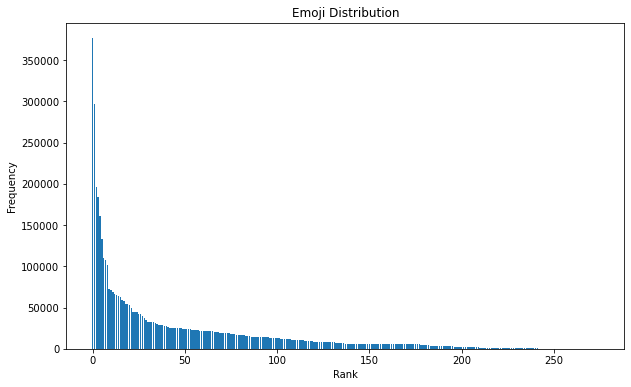

In [69]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_counts)), sorted_counts.values())
ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")
ax.set_title("Emoji Distribution")

del fig, ax